In [83]:
library(data.table)
library(rpart)
library(partykit)
library(ggplot2)
library(genlasso)
library(Metrics)
library(caret)
options(repr.plot.width=10, repr.plot.height=4)

### Data Manipulation and Visualization

In [2]:
train_data <- fread("C:/Users/kaan9/OneDrive/Masaüstü/CBF/CBF_TRAIN.txt")
setnames(train_data,'V1','class')
train_data=train_data[order(class)]
train_data[,class:=as.character(class)]
train_data[,id:=1:.N]
long_train=melt(train_data,id.vars=c('id','class'))
long_train[,time:=as.numeric(gsub("\\D", "", variable))-1]
long_train=long_train[,list(id,class,time,value)]
long_train=long_train[order(id,time)]

First, the series data transformed to long format because wide data format is hard to apply. There are 3 main classes of the CBF that which are cylinder, bell and funnel type series. Graph of the each series depending on their class is shown below.

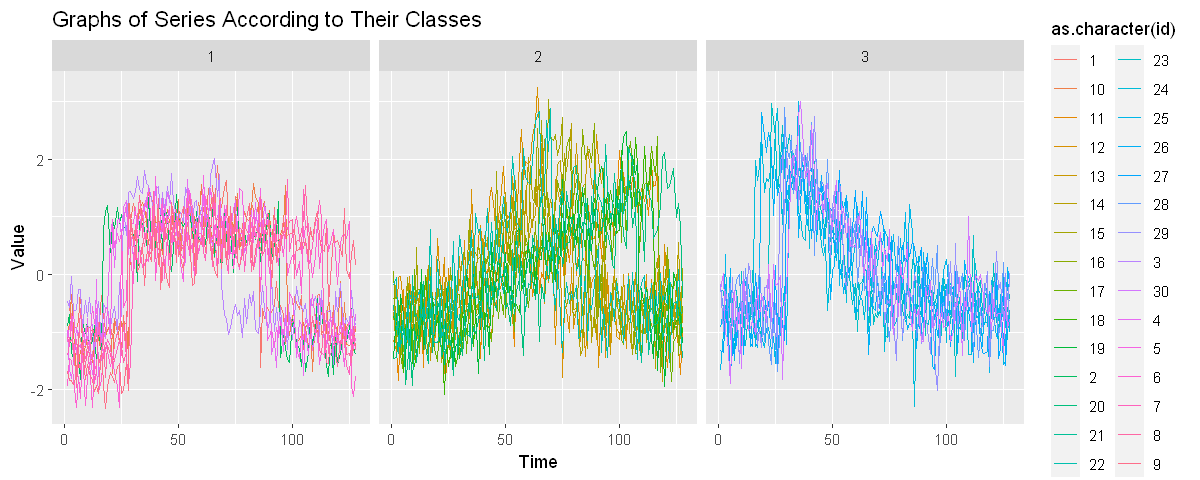

In [3]:
ggplot(long_train, aes(time,value)) + geom_line(aes(color=as.character(id))) +
     facet_wrap(~class) +
     labs(title= "Graphs of Series According to Their Classes", x= "Time", y="Value")

### 1D Fused Lasso Approximation

Before the representation of all series, one specific time series is selected to apply Fused Lasso. "genlasso" package is used and "cv.trendfilter" function uses 10 fold cross validation to find the best lambda value which minimizes the cross-validation error. In addition the one standard error rule is applied to lambda values to produce a more regularized estimate. More information about the "genlasso" package could be find in HERE.

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... Fold 6 ... Fold 7 ... Fold 8 ... Fold 9 ... Fold 10 ... 


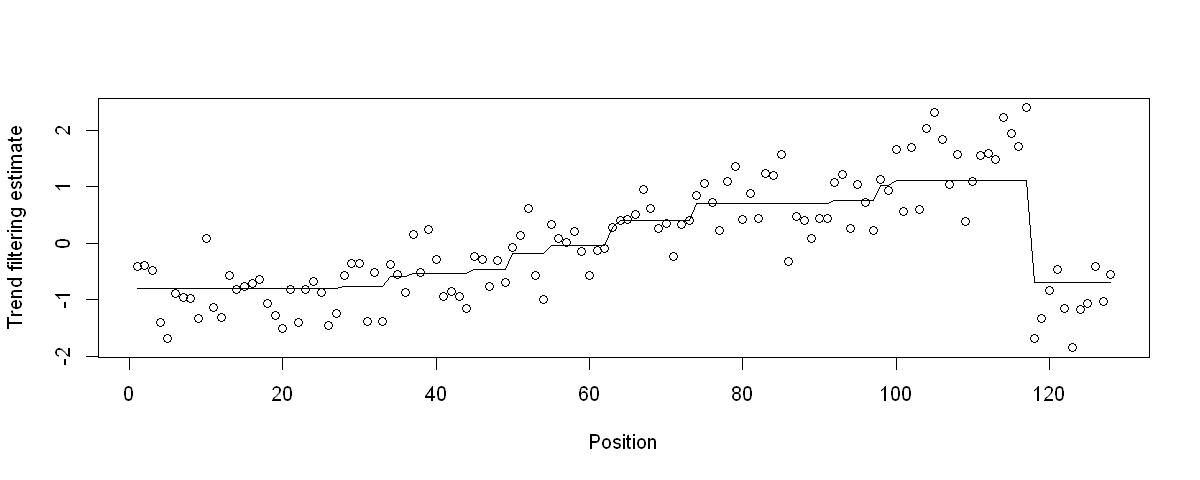

In [4]:
selected_dt <- long_train[id==17]
out <- fusedlasso1d(selected_dt$value)
cv_lasso <- cv.trendfilter(out,k=10)
plot(out,lambda=cv_lasso$lambda.1se)

After finding the best lambda paramter, predictions are made and the graph of the actual and predicted values is shown below.

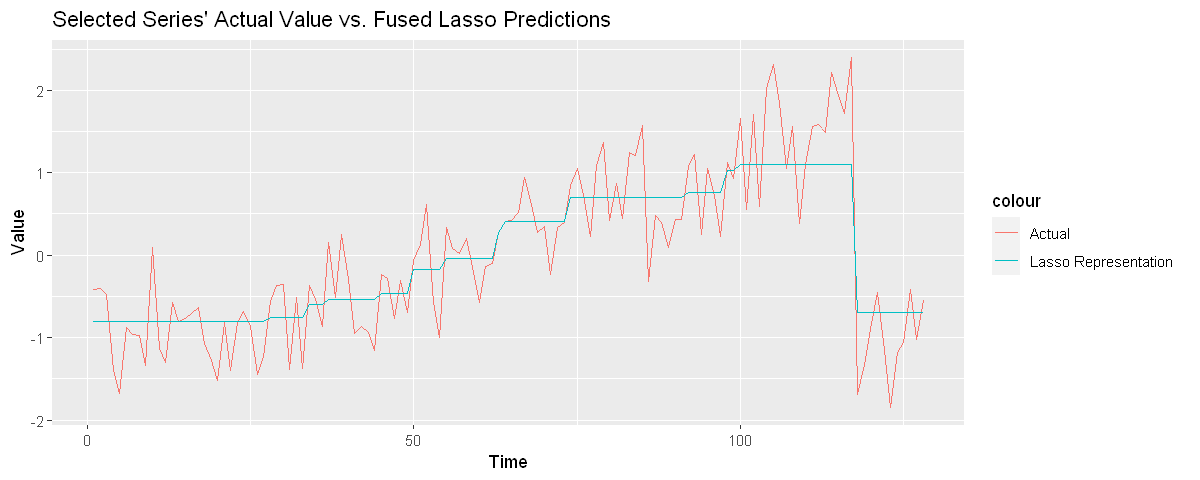

In [5]:
pred_lasso <- predict.genlasso(out,lambda=cv_lasso$lambda.1se)
selected_dt$pred_lasso <- pred_lasso$fit
ggplot(selected_dt,aes(x=time)) + 
     geom_line(aes(y = value,color="Actual")) +
     geom_line(aes(y = pred_lasso,color="Lasso Representation")) +
     labs(title= "Selected Series' Actual Value vs. Fused Lasso Predictions", x= "Time", y="Value")

### Adaptive Piecewise Approximation with Tree Algorithm

"caret" package is used for consturct a "rpart" tree model. "minsplit", "minbucket" and "cp" parameters are fixed at given values. "train" function applies 10 folds cross-validation process to find the best "maxdepth" parameter according to the root mean squared error. For the selected series RMSE rate is minimum at the "maxdepth" value of 5 which is shown in the table below. More information about the "caret" package could be found HERE.

In [6]:
selected_tree <- train(value~time,
                   minsplit=20,
                   minbucket=10,
                   cp=0,
                   data=selected_dt, 
                   method = "rpart2", 
                   trControl = trainControl(method="cv",number=10),
                   tuneGrid = expand.grid(.maxdepth=1:10),
                   metric = "RMSE"
                 )
selected_tree$results
selected_dt$pred_tree <- predict(selected_tree)

maxdepth,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
1,0.7968352,0.4160860,0.6174273,0.1736005,0.2050550,0.1055114
2,0.6618643,0.5915394,0.5220589,0.1972408,0.2111340,0.1219948
3,0.6108275,0.6619547,0.4836562,0.2229454,0.2270983,0.1508924
4,0.5884935,0.6904264,0.4835494,0.2347604,0.2346854,0.1593641
5,0.5630220,0.7065354,0.4583114,0.2168138,0.2239859,0.1347679
6,0.5630220,0.7065354,0.4583114,0.2168138,0.2239859,0.1347679
7,0.5630220,0.7065354,0.4583114,0.2168138,0.2239859,0.1347679
8,0.5630220,0.7065354,0.4583114,0.2168138,0.2239859,0.1347679
9,0.5630220,0.7065354,0.4583114,0.2168138,0.2239859,0.1347679
10,0.5630220,0.7065354,0.4583114,0.2168138,0.2239859,0.1347679


With the best "maxdepth" value the tree model is constructed and predictions are made. Representation of the selected series with the adaptive piecewise approximation is shown below.

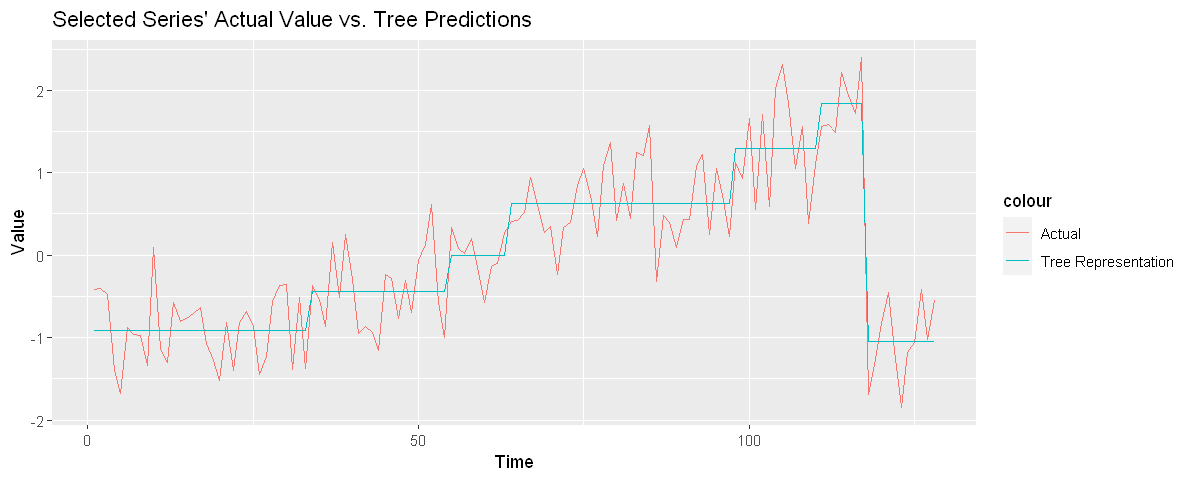

In [7]:
ggplot(selected_dt,aes(x=time)) + 
     geom_line(aes(y = value,color="Actual")) +
     geom_line(aes(y = pred_tree,color="Tree Representation")) +
     labs(title= "Selected Series' Actual Value vs. Tree Predictions", x= "Time", y="Value")

### Comparison of the Approximation Methods

For the selected series, graph of the different representations and actual values are shown below in the graph. The two methods are applied to only 1 of the time series. To find the which method fits well to the data, models are applied to each time series and mean squared error values are calculated.

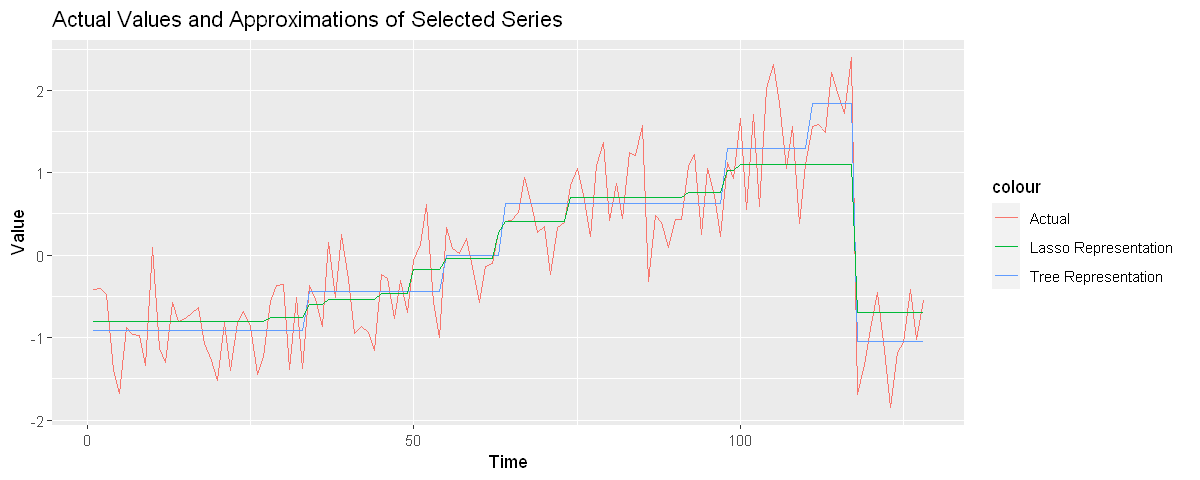

In [8]:
ggplot(selected_dt,aes(x=time)) + 
     geom_line(aes(y = value,color="Actual")) +
     geom_line(aes(y = pred_tree,color="Tree Representation")) +
     geom_line(aes(y = pred_lasso,color="Lasso Representation")) +
     labs(title= "Actual Values and Approximations of Selected Series", x= "Time", y="Value")

In [9]:
id_vec <- numeric(0)
lambda_vec <- numeric(0)
mse_vec <- numeric(0)
pred_lasso <- numeric(0)
for(i in unique(long_train$id)){
    id_vec <- c(id_vec,i)
    temp_data <- long_train[id==i]
    temp_out <- fusedlasso1d(temp_data$value)
    temp_cv <- cv.trendfilter(temp_out,k=10)
    lambda_vec <- c(lambda_vec,temp_cv$lambda.1se)
    temp_pred <- predict.genlasso(temp_out,lambda=temp_cv$lambda.1se)
    pred_lasso <- c(pred_lasso,as.vector(temp_pred$fit))
    temp_mse <- mse(temp_data$value,predicted = as.vector(temp_pred$fit))
    mse_vec <- c(mse_vec,temp_mse)
}
results <- data.table("id"=id_vec,"best_lambda"=lambda_vec,"MSE_Lasso"=mse_vec)

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... Fold 6 ... Fold 7 ... Fold 8 ... Fold 9 ... Fold 10 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... Fold 6 ... Fold 7 ... Fold 8 ... Fold 9 ... Fold 10 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... Fold 6 ... Fold 7 ... Fold 8 ... Fold 9 ... Fold 10 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... Fold 6 ... Fold 7 ... Fold 8 ... Fold 9 ... Fold 10 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... Fold 6 ... Fold 7 ... Fold 8 ... Fold 9 ... Fold 10 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... Fold 6 ... Fold 7 ... Fold 8 ... Fold 9 ... Fold 10 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... Fold 6 ... Fold 7 ... Fold 8 ... Fold 9 ... Fold 10 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... Fold 6 ... Fold 7 ... Fold 8 ... Fold 9 ... Fold 10 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... Fold 6 ... Fold 7 ... Fold 8 ... Fold 9 ... Fold 

In [10]:
mse_tree <- numeric(0)
max_depth <- numeric(0)
pred_tree <- numeric(0)
for(i in unique(long_train$id)){
    temp_data <- long_train[id==i]
    temp_tree <- train(value~time,
                        minsplit=20,
                        minbucket=10,
                        cp=0,
                        data=temp_data, 
                        method = "rpart2", 
                        trControl = trainControl(method="cv",number=10),
                        tuneGrid = expand.grid(.maxdepth=1:20),
                        metric = "RMSE"
                        )
    max_depth <- c(max_depth,temp_tree$bestTune[1])
    temp_pred <- predict(temp_tree)
    pred_tree <- c(pred_tree, as.vector(temp_pred))
    temp_mse <- mse(temp_data$value,predicted = as.vector(temp_pred))
    mse_tree <- c(mse_tree,temp_mse)
}

After the application of the models, the data table of mean squared values of the methods and their best parameters ate shown below. 21 of the 30 time series, the MSE value of the adaptive piecewise approximation method is lower than the 1D Fused Lasso method.

In [14]:
long_train$pred_lasso <- pred_lasso
long_train$pred_tree <- pred_tree
results$best_depth <- max_depth
results$MSE_tree <- mse_tree
head(results)
nrow(results[MSE_tree<=MSE_Lasso,])

id,best_lambda,MSE_Lasso,best_depth,MSE_tree
1,5.153002,0.12385476,1,0.64435232
2,3.683189,0.12151858,2,0.10634240
3,1.767117,0.09309762,2,0.09468449
4,2.709997,0.11448341,2,0.11085101
5,4.057839,0.12286685,2,0.10769060
6,3.058353,0.16815165,1,0.28336594


[1] 21

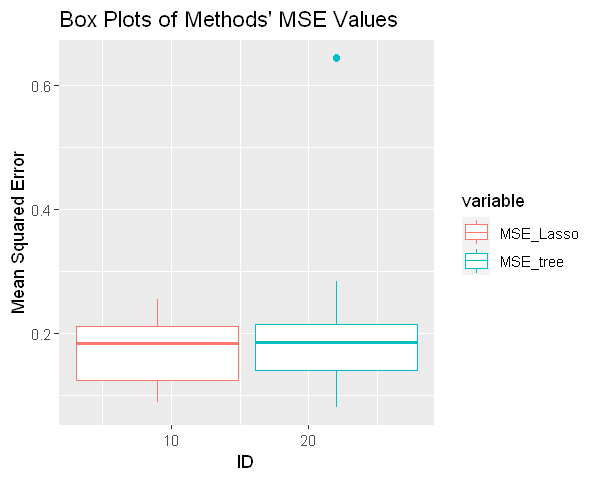

In [12]:
options(repr.plot.width=5, repr.plot.height=4)
data_plot <- melt(results,id.vars='id', measure.vars=c('MSE_Lasso','MSE_tree'))
ggplot(data_plot) +
    geom_boxplot(aes(x=id,y=value,color=variable)) +
    labs(title= "Box Plots of Methods' MSE Values", x= "ID", y="Mean Squared Error")

According to the boxplots of MSE values for both methods, Lasso approximation has better performance when the median and the quarters are examined. However, there is some outliers in the MSE values of tree approximation which could cause the shift in the values. Because MSE of tree representations overcome the MSE of Lasso representation in most of the series.

### Accuracy of 1-NN Classifier

To see the whether raw data or the representation is more accurate, 1-NN classification is applied to raw data, 1D Fused Lasso representation and Piecewise Adaptive Representation with trees. Algorithm for the classifier and the prediction results are shown below.

In [31]:
raw_distance <- matrix(0,nrow=length(unique(long_train$id)),ncol=length(unique(long_train$id)))
lasso_distance <- matrix(0,nrow=length(unique(long_train$id)),ncol=length(unique(long_train$id)))
tree_distance <- matrix(0,nrow=length(unique(long_train$id)),ncol=length(unique(long_train$id)))

for(i in unique(long_train$id)){
    for(j in unique(long_train$id)){
        raw_distance[i,j] <- sum((long_train[id==i,]$value-long_train[id==j,]$value)^2)
        lasso_distance[i,j] <- sum((long_train[id==i,]$pred_lasso-long_train[id==j,]$pred_lasso)^2)
        tree_distance[i,j] <- sum((long_train[id==i,]$pred_tree-long_train[id==j,]$pred_tree)^2)
    }    
}


In [78]:
id_vec <- numeric(0)
class_vec <- numeric(0)
raw_vec <- numeric(0)
lasso_vec <- numeric(0)
tree_vec <- numeric(0)
for(i in unique(long_train$id)){
    id_vec <- c(id_vec,i)
    class_vec <- c(class_vec,unique(long_train[id==i,class]))
    raw_vec <- c(raw_vec,unique(long_train[id==which.min(raw_distance[i,][raw_distance>0]),class]))
    lasso_vec <- c(lasso_vec,unique(long_train[id==which.min(lasso_distance[i,][lasso_distance>0]),class]))
    tree_vec <- c(tree_vec,unique(long_train[id==which.min(tree_distance[i,][tree_distance>0]),class]))
}
knn_classifier <- data.table(id=id_vec,class=class_vec,raw_pred=raw_vec,lasso_pred=lasso_vec,tree_pred=tree_vec)

In [79]:
knn_classifier

id,class,raw_pred,lasso_pred,tree_pred
1,1,3,3,1
2,1,1,1,1
3,1,1,1,1
4,1,1,1,1
5,1,1,1,1
6,1,1,1,1
7,1,1,1,1
8,1,1,1,1
9,1,1,1,1
10,1,1,1,1


In [82]:
accuracy_data <- cbind("Raw_Data"=accuracy(knn_classifier$class,knn_classifier$raw_pred),
                       "Lasso_Representation"=accuracy(knn_classifier$class,knn_classifier$lasso_pred),
                        "Tree_Representation"=accuracy(knn_classifier$class,knn_classifier$tree_pred))
accuracy_data

Raw_Data,Lasso_Representation,Tree_Representation
0.9,0.9,0.9333333


According to the accuracy of the classification, 1-NN classifier has the accuracy of 0.9 with raw data and 1D Fused Lasso representation and has 0.934 accuracy with the Piecewise Adaptive Representation. 

### Conclusion

After the certain data manipuation and visualition steps, 30 time series of the CBF data are represented both with 1D Fused Lasso and Adaptive Piecewise Representation. Mean squared values are calculated for both methods and tree representations has lower MSE values for the most of the series, but it has some outliers. Then, 1-NN classifier is applied to raw and represented data. While raw data and the 1D Fused Lasso Representation has the accuracy of 0.9, Adaptive Piecewise Model Representation has the accuracy of 0.934. 